# Sahte Fotoğraf Analizi Notebook Dosyası

# Kütüphane İşlemleri

In [1]:
#kütüphaneleri ekleme
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

# ELA İşlemleri

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

## Datasetteki gerçek bir fotoğrafı ekleyelim

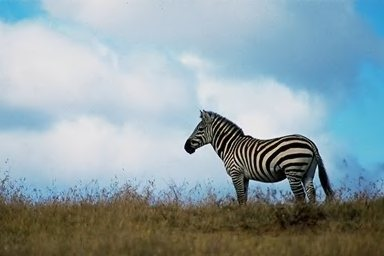

In [4]:
real_image_path = 'casia-dataset/casia/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

## Datasetteki gerçek bir fotoğrafın ELA sonrası hali

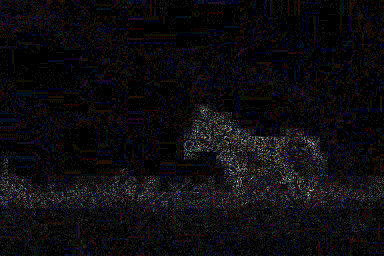

In [5]:
convert_to_ela_image(real_image_path, 90)

## Datasetteki sahte bir fotoğrafı ekleyelim

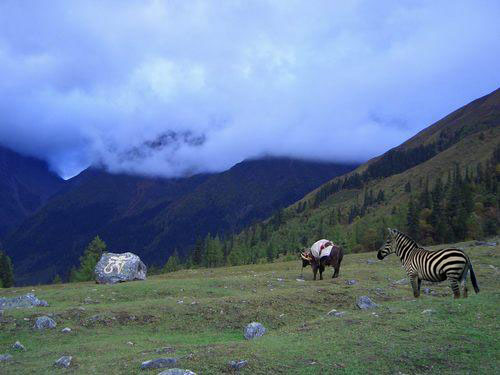

In [6]:
fake_image_path = 'casia-dataset/casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

## Datasetteki sahte bir fotoğrafın ELA sonrası hali

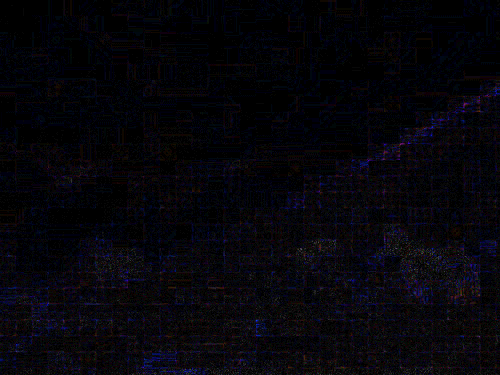

In [7]:
convert_to_ela_image(fake_image_path, 90)

## İnternetten alınmış gerçek bir görsel ekleyelim

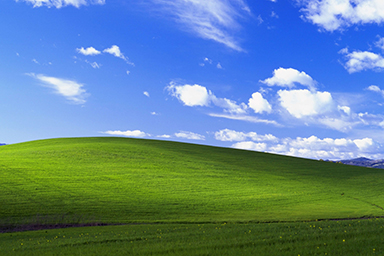

In [8]:
real_image_path = 'real.jpg'
Image.open(real_image_path)

## İnternetteki gerçek bir fotoğrafın ELA sonrası hali

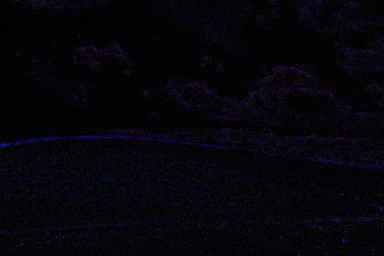

In [9]:
convert_to_ela_image(real_image_path, 90)

## İnternetten alınmış gerçek görsel üzerinde oynamalar yapalım

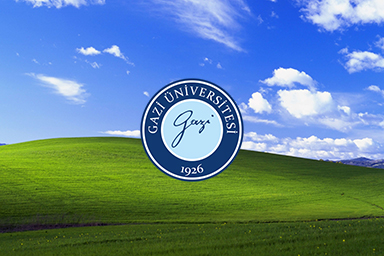

In [10]:
real_image_path = 'fake.jpg'
Image.open(real_image_path)

## İnternetten alınmış ve üzerinden oynanmış görselin ELA sonrası hali

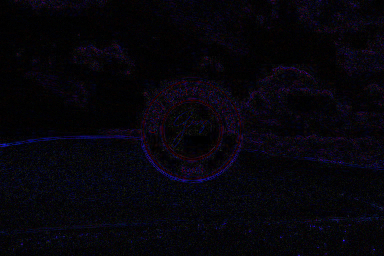

In [11]:
convert_to_ela_image(real_image_path, 90)

# Dataset Hazırlığı

In [12]:
image_size = (128, 128)

In [13]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [14]:
X = [] # ELA dönüşümü yapılmış görseller
Y = [] # 0 sahte, 1 gerçek 

Au => 7354 gerçek resim arasından 2100 tane rastgele alınır
Tp => 2064 sahte resim alınır

In [15]:
import random
path = 'casia-dataset/casia/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'{len(Y)} adet görsel işleniyor')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]

500 adet görsel işleniyor
1000 adet görsel işleniyor
1500 adet görsel işleniyor
2000 adet görsel işleniyor
2500 adet görsel işleniyor
3000 adet görsel işleniyor
3500 adet görsel işleniyor
4000 adet görsel işleniyor
4500 adet görsel işleniyor
5000 adet görsel işleniyor
5500 adet görsel işleniyor
6000 adet görsel işleniyor
6500 adet görsel işleniyor
7000 adet görsel işleniyor


In [16]:
path = 'casia-dataset/casia/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'{len(Y)} adet görsel işleniyor')


2500 adet görsel işleniyor
3000 adet görsel işleniyor
3500 adet görsel işleniyor
4000 adet görsel işleniyor


In [17]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

Train ve Test dataları %80-%20 şeklinde ayrılıyor

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


# Metaveri Analizi İşlemleri

# CNN Tahmin ve Sonuç İşlemleri